# **Machine Learning Reconstruction of Surface Ocean pCO₂**
Spring 2025, EESC4243/STAT4243/5243 “Climate Prediction Challenges with Machine Learning”, Columbia University

## Introduction 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

How good are these methods? Since the real full-coverage pCO2 of the ocean is unknown, we need another approach to assess the skill of ML-based reconstructions. Our answer is the **Large Ensemble Testbed (LET)**, which provides full-coverage pCO₂ output from Earth System Models, as well as associated driver varibles also from the ESM. In the context of this testbed, we can sample the pCO2 in the same pattern as real-world SOCAT and then reconstruct. Since the full-field pCO2 field is known ("Model Truth"), we can directly evaluate of ML reconstruction performance. With this approach, it has been shown that ML methods can capture seasonal variability well, they often overestimate decadal variability, particularly in regions with limited data coverage (Gloege et al. 2021).

This study builds upon previous work by incorporating a **pCO₂-Residual** approach to improve ML-based pCO₂ reconstructions. The **pCO₂-Residual** method removes the temperature-driven component from pCO₂ before applying ML, thereby reducing the dominance of temperature in predictions and enhancing the ability of the model to capture non-temperature-driven variability. 


We reproduce a portion of the analysis carried out by  
**Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* **Global Biogeochemical Cycles** 34: e2020GB006788.  
([DOI: 10.1029/2020GB006788](https://doi.org/10.1029/2020GB006788))  

using the method of  
**Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"*. **Journal of Advances in Modeling Earth Systems**, 14(10). ([DOI: 10.1029/2021ms002960](https://doi.org/10.1029/2021ms002960))

Our study:
1. Implements an **XGBoost-based pCO₂-Residual reconstruction**  (Bennington et al. 2022).
2. Evaluates reconstruction performance using a Large Ensemble Testbed, with **bias and correlation metrics** as in Gloege et al (2021).


### Running Notes
1. Users need to enter their GitHub/LEAP-Pangeo username at the end of Section 2.
2. Several time-consuming steps have outputs saved to files, so they only need to be run initially or if changes are made:  
    - Section 4.3: ML Training (~1 minute/ESM member)  
    - Section 4.4: Reconstruction/Inference (~1 minute/ESM member)  
    - Section 4.4.1: Summation of pCO2-Residual and pCO2-T to recover pCO2 (~15 seconds/ESM member)


    With a **128GB CPU**, actual runtimes may vary based on system load and selected members, but this serves as a general guideline.


## Important Controls:  
- **your_username**: The username of the person running the code.  
- **owner_username**: The username of the notebook owner.  
- **runthiscell**: Default = 1.  
  - **Disable a cell by setting `runthiscell=0`**.  
  - **Reviewers should set `runthiscell=-1` to save time and space**.  

### Instructions:  
- **If you're running your own code**:  
  - 'your_username' should be the same as 'owner_username' (both should be your account name).  
  - Disable a cell by setting 'runthiscell=0'.  

- **If you're a reviewer**:  
  - Set `your_username` to your own name while keeping `owner_username` as the notebook owner's name.  
  - Set `runthiscell=-1`.  
  - Run only the first member of the first ESM and load ML results for the other members from the owner's saved bucket file.

In [1]:
your_username = ''  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'alessandrocastillo'  # Reviewer should not change this name

## Overview of the Large Ensemble Testbed Approach

This figure (Figure 1 of Gloege et al. 2021) illustrates the main steps in the pCO₂ reconstruction workflow using the Large Ensemble Testbed. 
Panel A shows the sampling, training, and reconstruction process, while panel B breaks down the reconstructed 
CO₂ flux into different temporal components for evaluation. 

In this project, we take a similar approach, but we remove the complication of the calculation of CO₂ flux from pCO₂. Results can be expected to be qualitatively the same. 


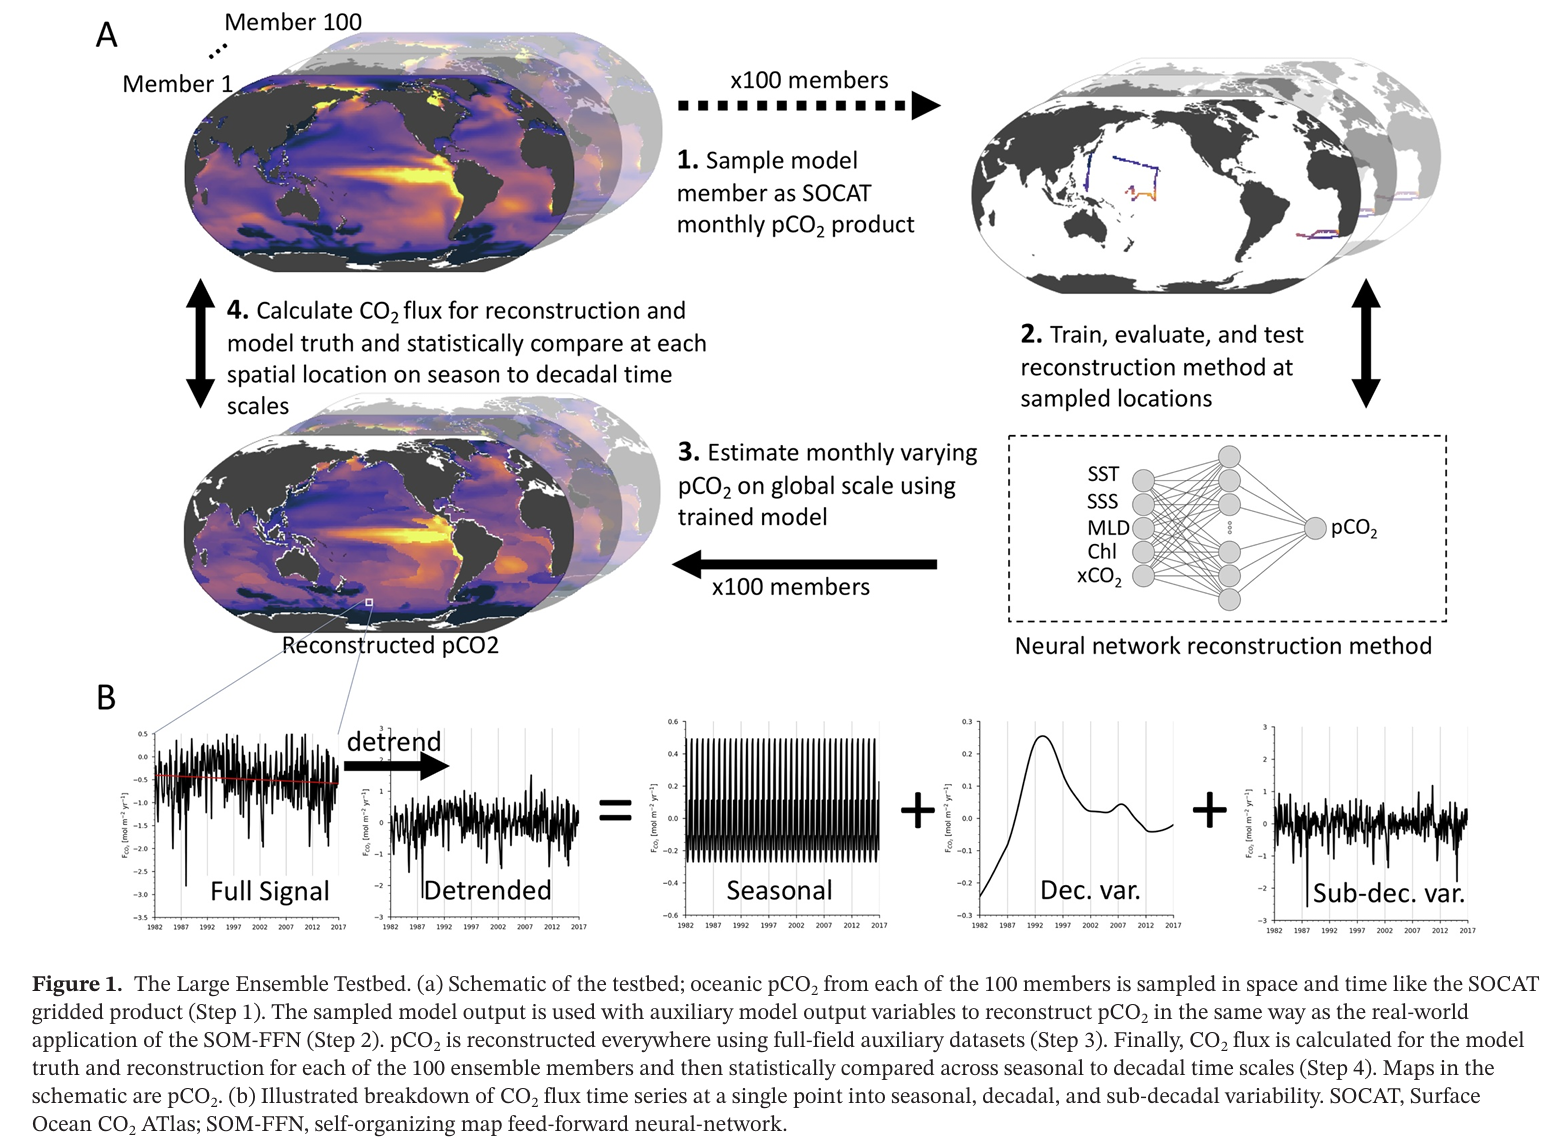

In [2]:
from IPython.display import Image
Image(filename="../images/figure1.png", width=1000)

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [3]:
!pip install keras
!python -m pip install --upgrade pip
!python -m pip install tensorflow

In [4]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


E0000 00:00:1745907887.415061     644 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745907887.419464     644 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745907887.430978     644 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907887.431003     644 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907887.431004     644 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907887.431005     644 computation_placer.cc:177] computation placer already registered. Please check linka

In [5]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

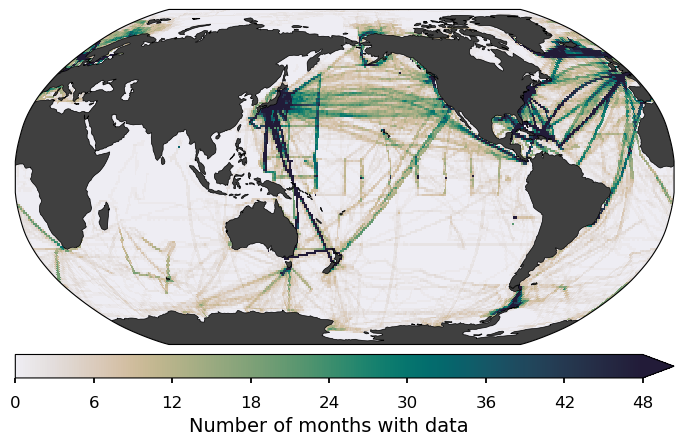

In [7]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
# socat_mask_data = xr.open_mfdataset(socat_path, engine='zarr').sel(time=slice(str(dates[0]),str(dates[-1])))

socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()


SOCAT data coverage is uneven, with some regions, particularly in the Southern Hemisphere and open ocean areas, having significantly fewer observations. Regions with denser observational coverage, such as the Northern Hemisphere, tend to have lower biases in CO2 flux reconstructions compared to sparsely sampled areas like the Southern Ocean.

# 2. Data Introduction and Storage

## **2.1 Input (Features) Sources**
The **input features** for the machine learning model are derived from **pre-processed Earth System Model (ESM) outputs or inputs**

### **Feature and Target Variables for the ML Model**
The features used for training the **pCO₂-Residual machine learning model** are listed below:


| **Feature** | **Description** | **ESM Input or Output?** | 
|------------|----------------|----------------|
| **SST (Sea Surface Temperature)** | Simulated ocean surface temperature | **ESM Output** |  
| **SST_anom** | SST anomaly from climatology | **ESM Output** |  
| **SSS (Sea Surface Salinity)** | Simulated surface ocean salinity | **ESM Output** |  
| **SSS_anom** | SSS anomaly from climatology | **ESM Output** |  
| **MLD_clim_log** | Log-transformed climatological mixed layer depth | **ESM Output** |  
| **Chl-a (Chlorophyll concentration)** | Proxy for biological activity (log-transformed) | **ESM Output** |  
| **Chl-a_anom** | Anomaly of Chl-a | **ESM Output** |  
| **xCO₂ (Atmospheric CO₂ concentration)** | Atmospheric CO₂ mole fraction | **ESM Input, from data** |  
| **A, B, C** | Space on the globe | **See Bennington et al. 2022, Table 1** |  
| **T0, T1** | Time | **See Bennington et al. 2022, Table 1** |  


The **target variable** for reconstruction is:
- **pCO₂-Residual**: This deviation from the temperature-driven component of pCO₂, reducing SST's dominance in ML reconstructions and improving model performance in data-sparse regions (detailed below).

### **Data Sources and Paths**
The data is stored in a **cloud environment, LEAP-Pangeo**, ensuring efficient access and scalability for the machine learning workflow. Key datasets include:

- **Ensemble dir**:

  Contains the original data from pre-processed Earth System Model (ESM) outputs, available for 100+ ESM members. For computational efficiency, we rely on a selection of this dataset compiled by TA Xinyi Ke. The full ensemble data is available and could be explored, with due consideration of storage constraints. 
  
- **ML Input and Target Data**:

    Provides a dataframe-format dataset containing preprocessed ML inputs and ground truth from a selected subset of ensemble members. You may also generate your own dataset for a custom selection or range of members (see reference: Project3_Data.ipynb). Due to limited GCS storage, we recommend using the provided dataset for most projects.
  
- **SOCAT Data (Mask File)**:  

  Masking file based on real-world **SOCAT pCO₂ observations**. Here, these data are not used directly, but are input solely so that their sampling pattern in space and time can be applied to model pCO2 fields, thus mimicing real-world observational density.

### **Key Considerations:**
- **pCO₂-Residual**: By removing the temperature-driven component from pCO₂, we enhance the ability of machine learning models to capture **non-temperature-driven variability**, particularly in poorly observed regions.
- **Data Subsampling Based on SOCAT**: The use of a **SOCAT-derived mask** ensures that the ML model is trained and evaluated using a realistic observational distribution, mitigating potential biases from uneven data coverage.

### **Final Input Structure**:
- **Feature Matrix**: `(N, 12)`, where `N` represents the number of samples, and 12 predictor variables are used.
- **Target Variable**: `pCO₂-Residual`, which the model aims to reconstruct.


In [8]:
# features for ML:
features_sel = ['sst','sst_anom','sss','sss_anom','mld_clim_log','chl_log','chl_log_anom','xco2','A', 'B', 'C', 'T0', 'T1']

# the target variable we reconstruct:
target_sel = ['pco2_residual'] # this represents pCO2 - pCO2-T (calculated in notebook 00)

 **Compute the temperature-driven component** of pCO₂:

$$
\text{pCO}_{2,T} = \overline{\text{pCO}_2} \cdot \exp\left[ 0.0423 \cdot (T - \overline{T}) \right]
$$

- $ \overline{\text{pCO}_2} $: long-term mean of surface ocean pCO₂  
- $ T $: sea surface temperature at a given time/location  
- $ \overline{T} $: long-term mean sea surface temperature  
- $ 0.0423 $: empirically derived constant (from Takahashi et al., 1993)


 **Subtract to get the residual**:

$$
\text{pCO}_{2,\text{Residual}} = \text{pCO}_2 - \text{pCO}_{2,T}
$$

This residual is then used as the **target variable** in ML training, helping disentangle the direct solubility-driven temperature effect from other biogeochemical processes.

In our workflow, this calculation was done during processing of the Earth System Model (ESM) dataset, not included in this notebook. The datasets under `ensemble_dir` include the variable `pCO2_T`. For this notebook, we will directly use the preprocessed ML input dataset, which includes `pco2_residual`.

Later in the notebook, we recover the total pCO2 by **adding the temperature component back** to the residual:

$$
\text{pCO}_2 = \text{pCO}_{2,\text{Residual}} + \text{pCO}_{2,T}
$$


In [9]:
### set up for getting files from leap bucket ###
fs = gcsfs.GCSFileSystem()

### paths for loading: ###
# directory of regridded members from notebook 00
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members" # path to regridded data
path_seeds = "gs://leap-persistent/abbysh/pickles/random_seeds.npy" # random seeds for ML

# directory of reference zarr files
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'

# socat data file
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"

# preprocessed ESM ensemble members
MLinputs_path = "gs://leap-persistent/Mukkke/pco2_residual/post01_xgb_inputs"

In [10]:
mems_dict = dict()

# Get all paths
all_paths = fs.ls(MLinputs_path)

for ens_path in all_paths:             
    ens = ens_path.split('/')[-1]
    mems = fs.ls(ens_path)
    for mem in mems:        
        memo = mem.split('/')[-1]
        if ens not in mems_dict:
            mems_dict[ens] = [memo]
        elif ens in mems_dict:
            mems_dict[ens].append(memo)

mems_dict

{'ACCESS-ESM1-5': ['member_r10i1p1f1',
  'member_r1i1p1f1',
  'member_r2i1p1f1',
  'member_r31i1p1f1',
  'member_r5i1p1f1'],
 'CanESM5': ['member_r1i1p1f1',
  'member_r1i1p2f1',
  'member_r2i1p1f1',
  'member_r3i1p2f1',
  'member_r6i1p2f1'],
 'MPI-ESM1-2-LR': ['member_r11i1p1f1',
  'member_r12i1p1f1',
  'member_r15i1p1f1',
  'member_r22i1p1f1',
  'member_r23i1p1f1'],
 'UKESM1-0-LL': ['member_r1i1p1f2',
  'member_r2i1p1f2',
  'member_r3i1p1f2',
  'member_r4i1p1f2',
  'member_r8i1p1f2']}

In [11]:
## Here you can change which models and how many members you use
random.seed(42)  # Set seed for reproducibility

selected_ensembles = ['ACCESS-ESM1-5', 'CanESM5', 'MPI-ESM1-2-LR']

selected_members_dict = {esm: mems_dict[esm] for esm in selected_ensembles}

selected_mems_dict = {}
num_members = 3  # Set the number of ensemble members from each ESM

for ens, members in selected_members_dict.items():
    if len(members) >= num_members:
        selected_mems_dict[ens] = random.sample(members, num_members)  # Select `num_members` random members
    else:
        selected_mems_dict[ens] = members  # If there are fewer members than `num_members`, select all

print(selected_mems_dict)

{'ACCESS-ESM1-5': ['member_r10i1p1f1', 'member_r5i1p1f1', 'member_r2i1p1f1'], 'CanESM5': ['member_r2i1p1f1', 'member_r1i1p2f1', 'member_r1i1p1f1'], 'MPI-ESM1-2-LR': ['member_r12i1p1f1', 'member_r11i1p1f1', 'member_r15i1p1f1']}


In [ ]:
# ── Build ML_df from pickle inputs ─────────────────────────────────────────
import pandas as pd

ML_dfs = []
for ens, members in selected_mems_dict.items():
    for member in members:
        fname = (
            f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_"
            f"{init_date}_{fin_date}.pkl"
        )
        file_path = f"{MLinputs_path}/{ens}/{member}/{fname}"
        with fs.open(file_path, 'rb') as f:
            df_piece = pd.read_pickle(f)
        ML_dfs.append(df_piece)

ML_df = pd.concat(ML_dfs, axis=0)
print(f"Loaded ML_df with {len(ML_df)} rows from {len(ML_dfs)} member files")

In [ ]:
init_date = date_start
fin_date = date_end
print('Using dates:', init_date, fin_date)

## 3. Temporal Lag Correlation Analysis

We assess how sea surface temperature (SST) influences variability in the pCO₂ residuals across different temporal lags.

In [ ]:
# Imports and style
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-talk')

In [ ]:
# Helper functions for lag analysis
def compute_lag_correlation(ds, target_var, driver_var, max_lag=12):
    lag_results = {}
    for lag in range(max_lag+1):
        shifted = ds[driver_var].shift(time=lag)
        both    = xr.concat([ds[target_var], shifted], dim='var').dropna('time')
        corr    = xr.corr(both.isel(var=0), both.isel(var=1), dim='time')
        lag_results[lag] = corr
    return xr.Dataset({f'lag_{lag}': lag_results[lag] for lag in lag_results})

def plot_lag_correlation_map(lag_ds, driver_var, target_var):
    fig, axes = plt.subplots(3, 4, figsize=(16,10),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()
    for i, lag in enumerate(sorted(int(k.split('_')[1]) for k in lag_ds.data_vars)):
        ax = axes[i]
        im = lag_ds[f'lag_{lag}'].plot(ax=ax,
                                       transform=ccrs.PlateCarree(),
                                       add_colorbar=False)
        ax.coastlines()
        ax.set_title(f"{driver_var}→{target_var} (lag {lag} mo)")
    fig.colorbar(im, ax=axes.tolist(), orientation='horizontal', pad=0.05)
    plt.tight_layout()
    return fig

In [ ]:
# 3.2 Load SOCAT dataset and ensure pCO₂ residual exists
fs = gcsfs.GCSFileSystem()
ds_socat = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

# If pco2_residual missing, derive from spco2 and pco2_T
if 'pco2_residual' not in ds_socat.data_vars:
    if 'spco2' in ds_socat.data_vars and 'pco2_T' in ds_socat.data_vars:
        ds_socat['pco2_residual'] = ds_socat['spco2'] - ds_socat['pco2_T']
    else:
        raise KeyError("Dataset must contain 'spco2' and 'pco2_T' to compute pCO₂ residual")

# Align SST and residual
ds_align = align_variables(ds_socat, allowed_nan_frac=0.2)

# Compute lag correlations
lag_ds = compute_lag_correlation(ds_align, 'pco2_residual', 'sst', max_lag=max_lag)

# Plot lag correlation maps
fig_lag = plot_lag_correlation_map(lag_ds, 'sst', 'pco2_residual')


In [ ]:
# =========================================================
# Dataset Alignment and Preparation with Robust NaN Handling
# =========================================================

def align_variables(ds, allowed_nan_frac=0.2):
    import numpy as np
    import xarray as xr
    
    # Essential variables
    common_vars = ['spco2', 'sst', 'sss', 'mld', 'xco2']
    if 'wind_stress' in ds:
        common_vars.append('wind_stress')
    # Calculate residual if pco2_T exists
    if 'pco2_T' in ds:
        ds['pco2_residual'] = ds['spco2'] - ds['pco2_T']
        common_vars.append('pco2_residual')
    # Mask
    if 'mask' in ds:
        ocean_mask = ds['mask'] > 0
    else:
        ocean_mask = xr.ones_like(ds[common_vars[0]].isel(time=0), dtype=bool)
    # Build nan masks
    nan_masks = []
    for var in common_vars:
        if var in ds:
            nan_frac = ds[var].isnull().mean(dim='time')
            nan_mask = nan_frac <= allowed_nan_frac
            nan_masks.append(nan_mask)
            invalid = int((~nan_mask).sum().item())
            print(f"{var}: {invalid} pixels exceed NaN frac")
    combined_mask = ocean_mask & np.logical_and.reduce(nan_masks)
    valid_count = int(combined_mask.sum().item())
    print(f"Total valid pixels: {valid_count}")
    # Apply mask
    for var in common_vars:
        if var in ds:
            ds[var] = ds[var].where(combined_mask)
    # Anomalies & seasonals
    for var in ['sst','sss','spco2']:
        if var in ds:
            clim = ds[var].groupby('time.month').mean('time')
            ds[f'{var}_anom'] = (ds[var].groupby('time.month') - clim).where(combined_mask)
    for var in ['sst','spco2']:
        if var in ds:
            ds[f'{var}_seasonal'] = ds[var].groupby('time.month').mean('time').where(combined_mask)
    return ds

# =========================================================
# Advanced Temporal Lag Analysis
# =========================================================

def compute_lag_correlation(ds, target_var, driver_var, max_lag=12):
    print(f"Computing lag correlation: {target_var} vs {driver_var}")
    import numpy as np
    import xarray as xr
    # check
    if target_var not in ds or driver_var not in ds:
        print("Variables missing.")
        return None
    target = ds[target_var]
    driver = ds[driver_var]
    lag_range = range(-max_lag, max_lag+1)
    corr_list = []
    for lag in lag_range:
        if lag>0:
            t = target.isel(time=slice(lag,None))
            d = driver.isel(time=slice(0,-lag))
        elif lag<0:
            t = target.isel(time=slice(0,lag))
            d = driver.isel(time=slice(abs(lag),None))
        else:
            t = target; d = driver
        if len(t.time)<3:
            corr = xr.full_like(target.isel(time=0), np.nan)
        else:
            corr = xr.corr(t, d, dim='time')
        corr_list.append(corr)
    corr_da = xr.concat(corr_list, pd.Index(lag_range,name='lag'))
    # optimal
    abs_corr = np.abs(corr_da)
    valid = abs_corr.notnull().any(dim='lag')
    abs_f = abs_corr.where(valid, other=-9999)
    idx = abs_f.argmax('lag').values
    lag_vals = np.array(list(lag_range))
    opt_lag = xr.DataArray(lag_vals, dims=['lag']).isel(lag=idx)
    opt_corr = corr_da.isel(lag=idx)
    return xr.Dataset({'correlation':corr_da,
                       'optimal_lag_value':opt_lag,
                       'optimal_lag_correlation':opt_corr})

def analyze_all_drivers(ds, target_vars=['spco2','pco2_residual'],
                       driver_vars=['sst','sss','wind_stress','xco2','mld','chl'],
                       max_lag=12):
    results={}
    for tv in target_vars:
        results[tv]={}
        for dv in driver_vars:
            if dv in ds:
                results[tv][dv] = compute_lag_correlation(ds, tv, dv, max_lag)
    return results

# Supporting plotting
def shift_to_360_and_add_cyclic(da, lon='xlon'):
    from cartopy.util import add_cyclic_point
    da2 = da.copy()
    if da2[lon].max()<=180:
        da2[lon] = (da2[lon]+360)%360
    da2 = da2.sortby(lon)
    vals, lons = add_cyclic_point(da2.values, coord=da2[lon].values)
    return xr.DataArray(vals, dims=da2.dims, coords={**da2.coords, lon:lons})

def plot_optimal_lag_maps(results, target_var, driver_vars, max_lag=12):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    from cartopy.util import add_cyclic_point
    n = len(driver_vars)
    fig, axes = plt.subplots(2, n, figsize=(4*n,8),
                             subplot_kw={'projection':ccrs.PlateCarree()})
    for i, dv in enumerate(driver_vars):
        res = results[target_var].get(dv)
        if res is None: continue
        opt_lag = shift_to_360_and_add_cyclic(res['optimal_lag_value'])
        opt_corr = shift_to_360_and_add_cyclic(res['optimal_lag_correlation'])
        im1 = axes[0,i].pcolormesh(opt_lag.xlon, opt_lag.ylat, opt_lag,
                                   transform=ccrs.PlateCarree(), cmap='twilight', vmin=-max_lag, vmax=max_lag)
        axes[0,i].coastlines(); axes[0,i].set_title(f'{dv} optimal lag')
        im2 = axes[1,i].pcolormesh(opt_corr.xlon, opt_corr.ylat, opt_corr,
                                   transform=ccrs.PlateCarree(), cmap='RdBu', vmin=-1, vmax=1)
        axes[1,i].coastlines(); axes[1,i].set_title(f'{dv} correlation')
    fig.colorbar(im1, ax=axes[0,:], orientation='horizontal', pad=0.05, label='lag')
    fig.colorbar(im2, ax=axes[1,:], orientation='horizontal', pad=0.05, label='corr')
    plt.tight_layout()
    return fig

def plot_regional_time_series(ds, results, target_var, driver_var, lat, lon, window=36):
    import matplotlib.pyplot as plt
    point = ds.sel(ylat=lat, xlon=lon, method='nearest')
    res = results[target_var][driver_var]
    opt_lag = int(res['optimal_lag_value'].sel(ylat=lat,xlon=lon,method='nearest').values)
    corr_val = res['optimal_lag_correlation'].sel(ylat=lat,xlon=lon,method='nearest').values
    target = point[target_var]
    driver = point[driver_var]
    tw = min(window, len(target.time))
    ttime = target.time.values[:tw]
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(ttime, target.values[:tw], 'b', label=target_var)
    ax2 = ax1.twinx()
    if opt_lag>0:
        drv = driver.values[:tw-opt_lag]
        tdrv = ttime[:-opt_lag]
    else:
        drv = driver.values[abs(opt_lag):tw]
        tdrv = ttime[abs(opt_lag):]
    ax2.plot(tdrv, drv, 'r', label=f'{driver_var} lag{opt_lag}')
    ax1.set_ylabel(target_var); ax2.set_ylabel(driver_var)
    ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
    ax1.set_title(f'{driver_var}->{target_var} @({lat},{lon}) lag={opt_lag}, corr={corr_val:.2f}')
    plt.tight_layout()
    return fig


In [ ]:
# ── Directory definitions ───────────────────────────────────────────────────
grid_search_approach     = 'nmse'
output_dir               = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post05_xgb'
model_output_dir         = f"{output_dir}/trained"
recon_output_dir         = f"{output_dir}/reconstructions"
metrics_output_dir       = f"{output_dir}/metrics"
test_perform_fname       = f"{metrics_output_dir}/xgb_test_performance_{init_date}-{fin_date}.csv"
unseen_perform_fname     = f"{metrics_output_dir}/xgb_unseen_performance_{init_date}-{fin_date}.csv"
xgb_model_save_dir       = f"{output_dir}/saved_models_{init_date}-{fin_date}"
xgb_model_local_save_dir = "output/model_saved"

# Extended+Lag output directories
output_dir_extlag        = output_dir.replace('post05_xgb','post05_xgb_extlag')
recon_output_dir_extlag  = f"{output_dir_extlag}/reconstructions"


## 4. ML Training: Baseline vs Extended-Mask + Lag XGBoost

Train XGBoost models and compare performance on test sets.

In [ ]:
# Train Baseline and Extended+Lag XGBoost Models
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

# Prepare DataFrames from ML_df
df_all = ML_df.reset_index()

# Baseline subset
df_base = df_all[df_all['socat_mask'] == 1].dropna(subset=features_sel + target_sel)
X_base = df_base[features_sel].values
y_base = df_base[target_sel].values.ravel()

# Extended mask + lag features
df_ext = df_all[df_all['extended_mask'] == 1].copy()
for lag in range(1, max_lag+1):
    df_ext[f'sst_lag_{lag}'] = df_ext['sst'].shift(lag)
df_ext = df_ext.dropna(subset=[f'sst_lag_{lag}' for lag in range(1, max_lag+1)] + target_sel)
lag_features = features_sel + [f'sst_lag_{lag}' for lag in range(1, max_lag+1)]
X_ext = df_ext[lag_features].values
y_ext = df_ext[target_sel].values.ravel()

# Split datasets
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_ext, y_ext, test_size=0.2, random_state=42)

# Train & save
os.makedirs(xgb_model_local_save_dir, exist_ok=True)
model_baseline = xgb.XGBRegressor(**params, random_state=42)
model_baseline.fit(Xb_train, yb_train, eval_metric='rmse', verbose=False)
model_baseline.save_model(f"{xgb_model_local_save_dir}/baseline.json")
fs.put(f"{xgb_model_local_save_dir}/baseline.json", f"{model_output_dir}/baseline.json")

model_extlag = xgb.XGBRegressor(**params, random_state=42)
model_extlag.fit(Xe_train, ye_train, eval_metric='rmse', verbose=False)
model_extlag.save_model(f"{xgb_model_local_save_dir}/extlag.json")
fs.put(f"{xgb_model_local_save_dir}/extlag.json", f"{model_output_dir}/extlag.json")

# Evaluate
yb_pred = model_baseline.predict(Xb_test)
ye_pred = model_extlag.predict(Xe_test)
rmse_base = mean_squared_error(yb_test, yb_pred, squared=False)
rmse_ext  = mean_squared_error(ye_test, ye_pred, squared=False)
print(f"Baseline RMSE: {rmse_base:.3f}")
print(f"Extended+Lag RMSE: {rmse_ext:.3f}")

## 4.4 Reconstruction

### What Are We Reconstructing?

After training the model, we generate pCO₂ predictions not just for evaluation but also for reconstructing spatial fields across different sample categories:

1. **`unseen_sel`**: These are grid points that are valid (no missing values, within physical bounds) but **not observed** in the SOCAT dataset (i.e., `socat_mask == 0`). Predictions on these samples (`y_pred_unseen`) test the model’s ability to generalize beyond observed regions.

2. **`sel`**: These are SOCAT-like samples where `socat_mask == 1`. They include both training and test data (depending on the year/month). Predictions here (`y_pred_seen`) are used to assess performance where observations exist.


### Explanation of Reconstruction Output Variables

Each column added to the DataFrame (`df`) serves a specific purpose in evaluation and reconstruction:

| Variable | Description |
|----------|-------------|
| `pCO2_truth` | The actual pCO₂ residual values|
| `pCO2_recon_full` | The full reconstruction result (predicted values across both SOCAT and unseen regions). |
| `pCO2_recon_unseen` | Predicted values only for unseen regions (where `socat_mask == 0`). |


If you have not changed your ML, the reconstruction step (~1 minute/member) does not need to be re-run

In [ ]:
runthiscell = 1  # 0 will turn off, 1 will turn on, -1 will only run the first member. Reviewers should set this to -1.

if runthiscell:

    if runthiscell == -1:
        print("Reviewing process: Running reconstrunction only for the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ensemble key
        first_mem = selected_mems_dict[first_ens][0]   # Get the first member in that ensemble
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dictionary with only the first ensemble and member
    else:
        run_selected_mems_dict = selected_mems_dict

    
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.parquet"
            file_path = f"{data_dir}/{fname}"
    
            model_path = f"{xgb_model_local_save_dir}/model_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.json"
         
            # model = xgb.XGBRegressor()
            # model.load_model(model_path)

            booster = xgb.Booster()
            booster.load_model(model_path)
            
            model = xgb.XGBRegressor()
            model._Booster = booster
            model._le = None              
            
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_parquet(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
            y_pred_unseen = model.predict(df.loc[unseen_sel, features_sel].to_numpy())
            y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
            
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            file_exists = fs.exists(unseen_perform_fname)
            with fs.open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('unseen performance metrics:', unseen_performance[ens][member])
    
            y_pred_seen = model.predict(X)
            
            df['pCO2_recon_full'] = np.nan
        
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            supporting_functions.save_recon(DS_recon, dates, recon_output_dir, ens, member)
        
    print('end of all members', datetime.datetime.now())

### 4.4.1 Add pCO2-Temperature back to reconstructed pCO2-Residual, thus recovering pCO2 

In [ ]:
runthiscell = 1  # 0 will turn off, 1 will turn on

if runthiscell:
    if runthiscell == -1:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        supporting_functions.calc_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)



**For the owner who completed the experiment and reconstructed the data:**

1. Ensure that the reconstruction data you saved under the specified path is clean, accurate, and ready for sharing.
2. Only the data you wish to save and provide to reviewers should be kept.
3. Change the permissions to allow others to read the data, ensuring it's accessible to reviewers.


**Reviewers should not run this cell**.


In [ ]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")
    
    prefix = f"{owner_username}/{owner_username}/pco2_residual/nmse/post02_xgb/reconstructions/"
    blobs = bucket.list_blobs(prefix=prefix)
    
    seen_dirs = set()  # Track top-level directories (immediate subdirectories of `reconstructions`)

    for blob in blobs:
        # Extract the relative path after `reconstructions/`
        relative_path = blob.name[len(prefix):]
        top_level_dir = relative_path.split("/")[0]  # Get first component

        try:
            # Make the file public
            blob.make_public()
            
            # Only print if it's a new top-level directory
            if top_level_dir not in seen_dirs:
                seen_dirs.add(top_level_dir)
                print(f"Made public: {top_level_dir}")
        except Exception as e:
            print(f"Failed to make public: {blob.name}")
            print(e)


###  4.4.3  Visualize the reconstruction for 1 month

In [ ]:
# Plot settings
plot_style = "seaborn-v0_8-talk"
cmap = cm.cm.thermal
cbar_title = 'pCO₂ (µatm)'
vrange = [280, 440]  # Colorbar range

# Select the first ensemble and member from the dictionary
first_ens = list(selected_mems_dict.keys())[0]
first_mem = selected_mems_dict[first_ens][0]

# Load original member data from ESM output
member_dir = f"{ensemble_dir}/{first_ens}/{first_mem}"
member_path = fs.glob(f"{member_dir}/*.zarr")[0]
# member_data = xr.open_mfdataset('gs://' + member_path, engine='zarr').sel(time=slice(str(dates[0]), str(dates[-1])))
member_data = xr.open_zarr('gs://' + member_path).sel(time=slice(str(dates[0]), str(dates[-1])))

# Load reconstructed pCO₂ data
recon_dir = f"{recon_output_dir}/{first_ens}/{first_mem}"    
recon_path = f"{recon_dir}/recon_pCO2_{first_ens}_{first_mem}_mon_1x1_{init_date}_{fin_date}.zarr"
full = xr.open_zarr(recon_path)["pCO2_recon_full"]

# Choose a specific month to visualize
chosen_time = '2021-01'
raw_data = member_data["spco2"].sel(time=chosen_time).squeeze()
recon_data = full.sel(time=chosen_time)[0, ...]

# Shift longitudes from [0, 360] to [-180, 180] for global plotting
raw_data = raw_data.roll(xlon=len(raw_data.xlon) // 2, roll_coords=True)
recon_data = recon_data.roll(xlon=len(recon_data.xlon) // 2, roll_coords=True)

# Load SOCAT mask and align longitude
mask = socat_mask_data.sel(time=chosen_time)["socat_mask"].squeeze()
mask = mask.roll(xlon=len(mask.xlon) // 2, roll_coords=True)

# Mask original data where SOCAT mask == 0
masked_raw = np.ma.masked_array(raw_data, mask=(mask == 0))

# Start plotting side-by-side
with plt.style.context(plot_style):
#    fig = plt.figure(figsize=(10, 4), dpi=200)
    fig = plt.figure(figsize=(8, 3), dpi=200)
    worldmap = SpatialMap2(
        fig=fig, region='world',
        cbar_mode='single',  # Use one shared colorbar
        colorbar=True,
        cbar_location='bottom',
        nrows_ncols=[1, 2]
    )

    # Plot original (masked) and reconstructed data
    sub0 = worldmap.add_plot(
        lon=raw_data['xlon'], lat=raw_data['ylat'], data=masked_raw,
        vrange=vrange, cmap=cmap, ax=0
    )
    sub1 = worldmap.add_plot(
        lon=recon_data['xlon'], lat=recon_data['ylat'], data=recon_data,
        vrange=vrange, cmap=cmap, ax=1
    )

    worldmap.set_title("Original pCO₂ (2021-01)", ax=0, fontsize=13)
    worldmap.set_title("Reconstructed pCO₂ (2021-01)", ax=1, fontsize=13)

    colorbar = worldmap.add_colorbar(sub0, ax=0)
    worldmap.set_cbar_xlabel(colorbar, cbar_title, fontsize=12)

    plt.show()


The figure compares the original sparse pCO₂ selected from the first ESM member, consistent with real-world sampling, and the corresponding machine-learning-based reconstruction for January 2021.

# 5. Evaluation of the reconstruction against the original model output

## 5. Evaluation of Reconstructions

Compare reconstruction metrics for Baseline vs Extended+Lag.

In [ ]:
# Load & evaluate reconstructions
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
import xarray as xr

# Baseline
datasets_b = []
for ens, members in selected_mems_dict.items():
    dsb = concat_datasets({ens: members}, recon_output_dir, init_date, fin_date)
    datasets_b.append(dsb)
ds_base = xr.concat(datasets_b, dim='ens')
eval_base = XarrayEvaluator(ds_base).compute_all_metrics().assign_coords(model='Baseline')

# Extended+Lag
datasets_e = []
for ens, members in selected_mems_dict.items():
    dse = concat_datasets({ens: members}, recon_output_dir_extlag, init_date, fin_date)
    datasets_e.append(dse)
ds_ext = xr.concat(datasets_e, dim='ens')
eval_ext = XarrayEvaluator(ds_ext).compute_all_metrics().assign_coords(model='Ext+Lag')

ds_eval = xr.concat([eval_base, eval_ext], dim='model')
print(ds_eval)

In [ ]:
# Plot comparisons
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

bias_b = eval_base['bias'].mean('ens').mean('time')
bias_e = eval_ext['bias'].mean('ens').mean('time')
corr_b = eval_base['corr'].mean('ens').mean('time')
corr_e = eval_ext['corr'].mean('ens').mean('time')

fig, axs = plt.subplots(2,2, figsize=(14,10), subplot_kw={'projection': ccrs.PlateCarree()})
_ = bias_b.plot(ax=axs[0,0], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, add_colorbar=False)
axs[0,0].set_title('Baseline Bias'); axs[0,0].coastlines()
_ = bias_e.plot(ax=axs[0,1], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, add_colorbar=False)
axs[0,1].set_title('Ext+Lag Bias'); axs[0,1].coastlines()
_ = corr_b.plot(ax=axs[1,0], transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, add_colorbar=False)
axs[1,0].set_title('Baseline Corr'); axs[1,0].coastlines()
_ = corr_e.plot(ax=axs[1,1], transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, add_colorbar=False)
axs[1,1].set_title('Ext+Lag Corr'); axs[1,1].coastlines()
fig.colorbar(axs[1,1].collections[0], ax=axs, orientation='horizontal', pad=0.05)
plt.tight_layout()